# Stolen Bases: A Matter of Skill or Guts?

<img src='https://img.mlbstatic.com/mlb-images/image/upload/t_2x1/t_w1536/mlb/yblyorebwvue0kwl7y0b.jpg' width='600' align='center'/>

# Business Understanding

MLB saw an increase in stolen bases in 2023. An MLB team wants to increase viewer retention rates and increase the fan base by adding more action into the game, and they've decided on joining the fun with stolen bases. In this project, I will be advising the MLB team on **how to increase SB stats** for their players. Is it a matter of skill or guts? While this MLB team wants to increase SB stats, they do not want it to jeopardize their wins.

I investigate the following questions:
1. Was the increase in stolen bases from 2022 to 2023 **significant**?
2. What contributes to a high number of **stolen bases**?

# Data Understanding

This data was extracted from a custom leaderboard I created on **Baseball Savant**. There are 2 datasets with the same format - [one from 2022](https://baseballsavant.mlb.com/leaderboard/custom?year=2022&type=batter&filter=&min=q&selections=r_total_caught_stealing%2Cr_total_stolen_base%2Cn_bolts%2Csprint_speed&chart=true&x=r_total_caught_stealing&y=r_total_caught_stealing&r=no&chartType=beeswarm&sort=r_total_stolen_base&sortDir=desc) and [one from 2023](https://baseballsavant.mlb.com/leaderboard/custom?year=2023&type=batter&filter=&min=q&selections=r_total_caught_stealing%2Cr_total_stolen_base%2Cn_bolts%2Csprint_speed&chart=true&x=r_total_caught_stealing&y=r_total_caught_stealing&r=no&chartType=beeswarm&sort=r_total_stolen_base&sortDir=desc). The data includes **CS** (caught stealing), **SB** (stolen base), **Bolts** and **Sprint Speed** from **players in the MLB** (Major League Baseball). The 2022 dataset has stats for 130 players and the 2023 dataset has stats for 133 players. This data has been collected from **Statcast**, "a state-of-the-art tracking technology, capable of measuring previously unquantifiable aspects of the game."([Baseball Savant](https://baseballsavant.mlb.com/about#:~:text=Where%20is%20the%20data%20from,probable%20pitchers%20for%20upcoming%20days.))

I began with importing the necessary libraries for my data preparation and exploratory data analysis. These libraries are for data manipulation and data visualization.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

I then imported the data as pandas dataframes. The 2022 data is saved as `df_2022` and the 2023 data is saved as `df_2023`.

In [2]:
# import datasets
df_2022 = pd.read_csv('stats_2022.csv')
df_2023 = pd.read_csv('stats_2023.csv')

## Data Preparation

Since the data was extracted from a custom leaderboard I created on [Baseball Savant](https://baseballsavant.mlb.com/), there was minimal cleaning that needed to be done. Both tables follow the same format so I will be following the same cleaning steps for each.

First, I previewed the first 5 entries of each table. This gives me a general idea on how I want to clean and handle the data. I notice:
1. I want to **clean the column names**.
2. I already see **NaNs for n_bolts**. I will have to decide how to handle that.
3. Team names are not included in the dataset. I could add team rosters to a variable and feature engineer a column for teams, but I am more **focused on specific players** stealing bases, not on overall team statistics.
4. On Baseball Savant, my customer leaderboard was **sorted** by descending stolen bases but the data did *not* import that way. I will keep that in mind as I proceed with my analysis.

In [3]:
# View the first 5 entries of 2022 data
df_2022.head()

,"last_name, first_name",player_id,year,r_total_caught_stealing,r_total_stolen_base,n_bolts,sprint_speed
0,"Thomas, Lane",657041,2022,4,8,39.0,29.4
1,"Canha, Mark",592192,2022,1,3,NaN,27.5
2,"Torres, Gleyber",650402,2022,5,10,NaN,26.9
3,"Acuña Jr., Ronald",660670,2022,11,29,25.0,28.5
4,"Mullins II, Cedric",656775,2022,10,34,18.0,28.5


In [4]:
# View the first 5 entries of 2023 data
df_2023.head()

,"last_name, first_name",player_id,year,r_total_caught_stealing,r_total_stolen_base,n_bolts,sprint_speed
0,"Candelario, Jeimer",600869,2023,1,8,NaN,27.5
1,"McMahon, Ryan",641857,2023,5,5,NaN,25.8
2,"Muncy, Max",571970,2023,2,1,NaN,26.9
3,"Soler, Jorge",624585,2023,0,1,NaN,26.6
4,"Edman, Tommy",669242,2023,4,27,7.0,28.8


In [5]:
# View the overall shape, dtypes and null counts for each column in df_2022
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   last_name, first_name    130 non-null    object 
 1   player_id                130 non-null    int64  
 2   year                     130 non-null    int64  
 3   r_total_caught_stealing  130 non-null    int64  
 4   r_total_stolen_base      130 non-null    int64  
 5   n_bolts                  44 non-null     float64
 6   sprint_speed             130 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 7.2+ KB


In [6]:
# View the overall shape, dtypes and null counts for each column in df_2023
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   last_name, first_name    133 non-null    object 
 1   player_id                133 non-null    int64  
 2   year                     133 non-null    int64  
 3   r_total_caught_stealing  133 non-null    int64  
 4   r_total_stolen_base      133 non-null    int64  
 5   n_bolts                  50 non-null     float64
 6   sprint_speed             133 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 7.4+ KB


Above I noticed as I viewed the overall makeup of the data that n_bolts is the only column with **nulls** in either dataframe. I want to handle these so I will investigate further.

In [7]:
# View random 20 entries where n_bolts is NaN
df_2023[df_2023['n_bolts'].isna()].sample(20)

,"last_name, first_name",player_id,year,r_total_caught_stealing,r_total_stolen_base,n_bolts,sprint_speed
43,"Tucker, Kyle",663656,2023,5,30,NaN,26.6
101,"Castellanos, Nick",592206,2023,2,11,NaN,27.2
77,"Bell, Josh",605137,2023,1,0,NaN,25.9
6,"Rosario, Eddie",592696,2023,4,3,NaN,28.0
17,"Rutschman, Adley",668939,2023,2,1,NaN,27.0
128,"Benintendi, Andrew",643217,2023,2,13,NaN,27.3
120,"Nootbaar, Lars",663457,2023,1,11,NaN,27.8
93,"France, Ty",664034,2023,0,1,NaN,25.0
7,"De La Cruz, Bryan",650559,2023,1,4,NaN,27.7
11,"Correa, Carlos",621043,2023,0,0,NaN,26.6


"A Bolt is any run where the Sprint Speed (defined as "feet per second in a player's fastest one-second window") of the runner is at least 30 ft/sec."([MLB](https://www.mlb.com/glossary/statcast/bolt)). All of the samples where Bolt is NaN include Sprint Speeds that are less than 30. Therefore, it seems safe to say that these players did not have any bolts. I will **change the NaNs to 0's**.

In [8]:
# Replace NaNs in N_Bolts with 0
df_2022['n_bolts'] = df_2022['n_bolts'].fillna(0)
df_2023['n_bolts'] = df_2023['n_bolts'].fillna(0)

Below shows the **summary statistics** of each dataset. Although all of the data below is numerical, player_id and year are categorical data, so those can be ignored. r_total_caught_stealing, r_total_stolen_base, n_bolts, and sprint_speed, however, give me a general overview of the values I expect to see in the data set.

I do notice the difference in r_total_stolen_base means from 2022 to 2023. The 2022 mean is 8.9 and the 2023 mean is 11.75. It is a difference of 2.85, but **is that significant?** I will analyze further in the EDA. 

In [9]:
# View summary statistics of df_2022
df_2022.describe()

,player_id,year,r_total_caught_stealing,r_total_stolen_base,n_bolts,sprint_speed
count,130.000000,130.0,130.000000,130.000000,130.000000,130.000000
mean,607829.930769,2022.0,2.638462,8.907692,7.338462,27.280769
std,61551.798138,0.0,2.572978,8.823371,20.286916,1.290820
min,443558.000000,2022.0,0.000000,0.000000,0.000000,24.000000
25%,571987.750000,2022.0,1.000000,2.000000,0.000000,26.400000
50%,622163.500000,2022.0,2.000000,6.000000,0.000000,27.350000
75%,663574.000000,2022.0,3.750000,13.750000,1.750000,28.200000
max,683734.000000,2022.0,12.000000,35.000000,131.000000,30.300000


In [10]:
# View summary statistics of df_2023
df_2023.describe()

,player_id,year,r_total_caught_stealing,r_total_stolen_base,n_bolts,sprint_speed
count,133.000000,133.0,133.000000,133.000000,133.000000,133.000000
mean,633932.578947,2023.0,2.796992,11.751880,7.541353,27.395489
std,49936.834584,0.0,2.859750,12.585108,22.734139,1.242301
min,457759.000000,2023.0,0.000000,0.000000,0.000000,24.300000
25%,605204.000000,2023.0,1.000000,3.000000,0.000000,26.400000
50%,656305.000000,2023.0,2.000000,8.000000,0.000000,27.400000
75%,666969.000000,2023.0,4.000000,16.000000,2.000000,28.300000
max,807799.000000,2023.0,15.000000,73.000000,149.000000,30.500000


Below I checked for **duplicates**. I didn't think there would be any but you never know!

In [11]:
# Check for duplicated
len(df_2022[df_2022.duplicated()])

0

In [12]:
# Check for duplicated
len(df_2023[df_2023.duplicated()])

0

In [13]:
# Rewrite column names in title case for preference
df_2022.columns = df_2022.columns.map(lambda x: x.title())
df_2023.columns = df_2023.columns.map(lambda x: x.title())

### Feature Engineering

I create two columns that will be useful in my analysis:
1. `Total_Steal_Attempts`
2. `Stolen_Base_%`: This one is a column on Baseball Savant but was empty, therefore I am calculating it here.

In [14]:
# Create Total_Steal_Attempts by adding R_Total_Caught_Stealing and R_Total_Stolen_Base
df_2022['Total_Steal_Attempts'] = df_2022['R_Total_Caught_Stealing'] + df_2022['R_Total_Stolen_Base']
df_2023['Total_Steal_Attempts'] = df_2023['R_Total_Caught_Stealing'] + df_2023['R_Total_Stolen_Base']

In [15]:
# Create %_Stolen_Base by adding R_Total_Caught_Stealing and R_Total_Stolen_Base
df_2022['Stolen_Base_%'] = df_2022['R_Total_Stolen_Base'] / df_2022['Total_Steal_Attempts']
df_2023['Stolen_Base_%'] = df_2023['R_Total_Stolen_Base'] / df_2023['Total_Steal_Attempts']

In [16]:
# Preview how the df looks now
df_2023.head()

,"Last_Name, First_Name",Player_Id,Year,R_Total_Caught_Stealing,R_Total_Stolen_Base,N_Bolts,Sprint_Speed,Total_Steal_Attempts,Stolen_Base_%
0,"Candelario, Jeimer",600869,2023,1,8,0.0,27.5,9,0.888889
1,"McMahon, Ryan",641857,2023,5,5,0.0,25.8,10,0.500000
2,"Muncy, Max",571970,2023,2,1,0.0,26.9,3,0.333333
3,"Soler, Jorge",624585,2023,0,1,0.0,26.6,1,1.000000
4,"Edman, Tommy",669242,2023,4,27,7.0,28.8,31,0.870968


In [17]:
# Concatenate the two dataframes
sb_data = pd.concat([df_2022, df_2023], axis=0)

# Export new dataframe to visualize in tableau
sb_data.to_csv('sb_data.csv')

# Exploratory Data Analysis

There are two things I am looking to explore in this Exploratory Data Analysis:
1. Was the increase in stolen bases from 2022 to 2023 **significant**?
2. What contributes to a high number of **stolen bases**?

## 1. Was the increase in stolen bases from 2022 to 2023 significant?

In order to determine if the increase in stolen bases from 2022 to 2023 was significant, I am going to conduct a **two sample t-test**. This will determine if there is a significant difference between the stolen base means from 2022 to 2023, as was reported in [articles](https://www.mlb.com/news/mlb-records-3000th-stolen-base-in-2023) and fans alike.

These are the steps I will take to conduct the hypothesis test:
1. Set up null and alternative hypotheses.
2. Choose a significance level.
3. Calculate the t-statistic.
4. Determine the critical or p-value.
5. Compare t-value with critical t-value to reject or fail to reject the null hypothesis.

Before begining the two sample t-test, I visualize each of the distributions on a **KDE plot**. There is a slight difference in distributions and definitely **warrants further investigation** to determine if these differences are significant or not. Each distribution is **skewed to the right**, as the outliers are from players with high SB. 

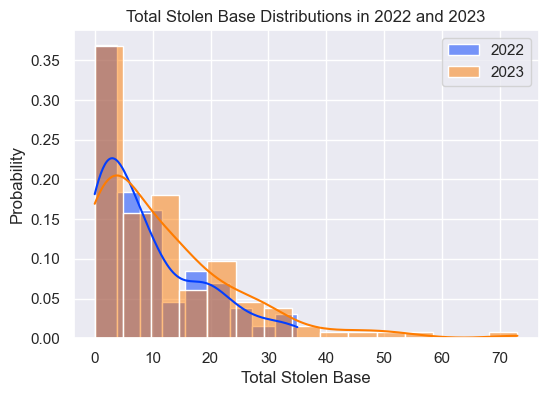

In [18]:
# Visualize distribution plots
sns.set_theme(context='notebook', palette='bright', rc={'figure.figsize':(6,4)})
sns.histplot(df_2022['R_Total_Stolen_Base'], kde=True, stat='probability', label='2022')
sns.histplot(df_2023['R_Total_Stolen_Base'], kde=True, stat='probability', label='2023')

# Label axes and title
plt.xlabel('Total Stolen Base')
plt.ylabel('Probability')
plt.title('Total Stolen Base Distributions in 2022 and 2023')

plt.legend();

### 1. Set up null and alternative hypotheses.

**Null Hypothesis**: The mean number of stolen bases in the MLB did not increase from 2022 to 2023.
<br>
**Alternative Hypothesis**: The mean number of stolen bases in the MLB increased from 2022 to 2023.

### 2. Choose a significance level.

I will choose the standard 5% significance level for this hypothesis test.

In [19]:
# Save 5% significance level as alpha for future use
alpha = 0.05

### 3. Calculate the critical t-value.

In [20]:
# Save n variables for critical t formula
n_2022 = len(df_2022['R_Total_Stolen_Base'])
n_2023 = len(df_2023['R_Total_Stolen_Base'])


# Calculate critical t-value with a 5% significance level for a one-tailed test
t_crit = stats.t.ppf(1-0.05,(n_2022+n_2023-2))
print(f'The critical t-value is {t_crit}.')

The critical t-value is 1.650712726541289.


### 4. Calculate the t-statistic and p-value.

In [21]:
t_stat, p_value = stats.ttest_ind(df_2023['R_Total_Stolen_Base'], df_2022['R_Total_Stolen_Base'])
print(f'The t-statistic is {t_stat} and the p-value is {p_value}.')

The t-statistic is 2.117726302313559 and the p-value is 0.03514387117074101.


### 5. Compare t-value with critical t-value to reject or fail to reject the null hypothesis.

With the following findings:
- t-statistic of approximately 2.1 and a critical t-value of 1.65
- alpha value of 5% and p-value of approximately 0.035
<br>

I **reject the null hypothesis** at a significance level of 5%.

The following t-distribution marks the critical t-value in red. This sections stretches to the right. The t-statistic is marked in black, which falls to the right of the critical t-value.

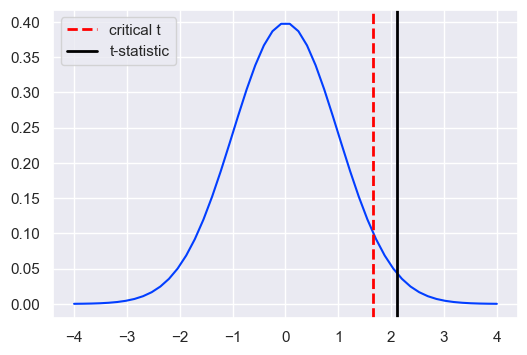

In [22]:
fig = plt.figure(figsize=(6,4))
x_axis = np.linspace(-4,4,50)
 
# use stats.t.pdf to get values on the probability density function for the t-distribution
y_axis = stats.t.pdf(x_axis, (n_2022+n_2023-2), 0, 1)

plt.plot(x_axis, y_axis)
    
# Draw one sided boundary for critical-t
plt.axvline(t_crit, color='red', linestyle='--', lw=2, label='critical t')
plt.axvline(t_stat, color='black', linestyle='-', lw=2, label='t-statistic')
plt.legend()
plt.show()

## 2. What contributes to a high number of stolen bases?

In order to increase SB for an MLB team, I am going to analyze the data from `df_2023`. Upon creating my customer leaderboard, I chose stats that are wideley accepted to have an effect on [SB (Stolen Base)](https://www.mlb.com/glossary/standard-stats/stolen-base): [Sprint Speed](https://www.mlb.com/glossary/statcast/sprint-speed), [Bolt](https://www.mlb.com/glossary/statcast/bolt), and SB Attempts. The relationship between SB and attempts is shown through the [SB% (Stolen Base Percentage)](https://www.mlb.com/glossary/standard-stats/stolen-base-percentage) column, which is SB divided by the total number of attempts.

Do players with a high number of stolen bases also have a great number of caught stolen?

array([[1.        , 0.72395428],
       [0.72395428, 1.        ]])

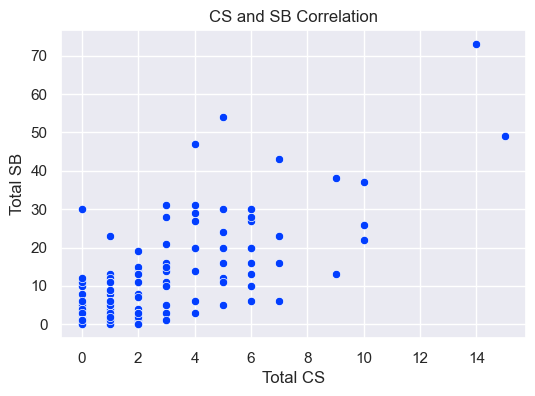

In [23]:
ax = sns.scatterplot(df_2023, x='R_Total_Caught_Stealing', y='R_Total_Stolen_Base')
ax.set_xlabel('Total CS')
ax.set_ylabel('Total SB')
ax.set_title('CS and SB Correlation');
corr = np.corrcoef(df_2023['R_Total_Caught_Stealing'], df_2023['R_Total_Stolen_Base'])
corr

array([[1.      , 0.645063],
       [0.645063, 1.      ]])

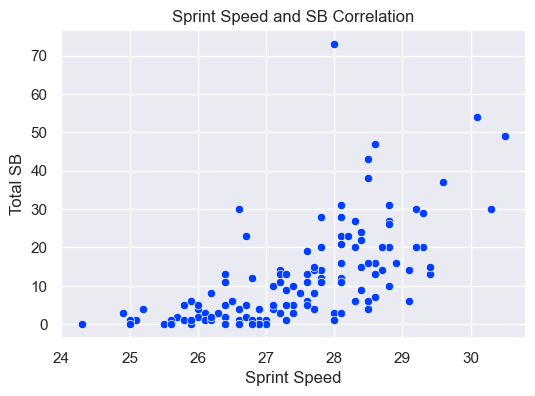

In [24]:
ax = sns.scatterplot(df_2023, x='Sprint_Speed', y='R_Total_Stolen_Base')
ax.set_xlabel('Sprint Speed')
ax.set_ylabel('Total SB')
ax.set_title('Sprint Speed and SB Correlation');
corr = np.corrcoef(df_2023['Sprint_Speed'], df_2023['R_Total_Stolen_Base'])
corr

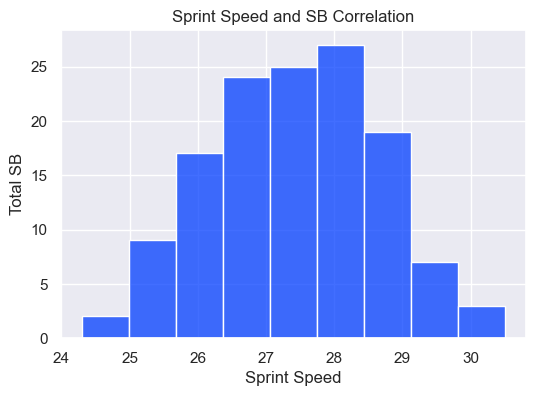

In [32]:
ax = sns.histplot(df_2023, x='Sprint_Speed')
ax.set_xlabel('Sprint Speed')
ax.set_ylabel('Total SB')
ax.set_title('Sprint Speed and SB Correlation');

array([[1.        , 0.54370247],
       [0.54370247, 1.        ]])

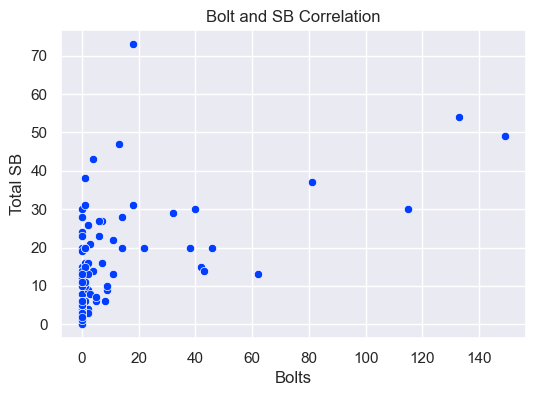

In [48]:
ax = sns.scatterplot(df_2023, x='N_Bolts', y='R_Total_Stolen_Base')
ax.set_xlabel('Bolts')
ax.set_ylabel('Total SB')
ax.set_title('Bolt and SB Correlation');
corr = np.corrcoef(df_2023['N_Bolts'], df_2023['R_Total_Stolen_Base'])
corr

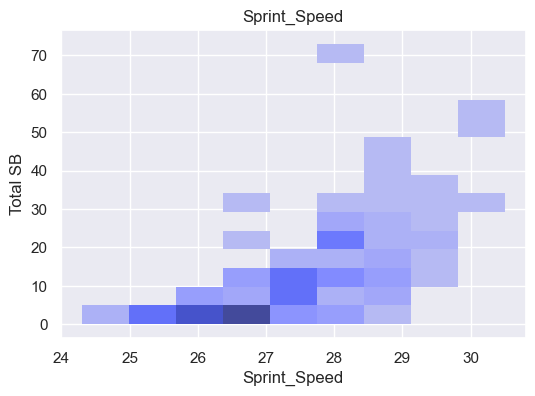

In [26]:
ax = sns.histplot(df_2023, x='Sprint_Speed', y='R_Total_Stolen_Base')
ax.set_xlabel('Sprint_Speed')
ax.set_ylabel('Total SB')
ax.set_title('Bolt and SB Correlation');

I am going to examine the stats of the players with the top 10 SB in 2023.

In [27]:
# Create df with players with top 10 SB
top_10_players = df_2023.sort_values('R_Total_Stolen_Base', ascending=False).iloc[:10]

# Reset the index to order from 1 to 10
top_10_players.reset_index(inplace=True, drop=True)
top_10_players.index = top_10_players.index + 1

**Ronald Acuña Jr.** of the Atlanta Braves lands in first place with **73 [stolen bases](https://www.mlb.com/glossary/standard-stats/stolen-base)**. He does not have the fastest [Sprint Speed](https://www.mlb.com/glossary/statcast/sprint-speed) at 28 and not nearly the highest [Number of Bolts](https://www.mlb.com/glossary/statcast/bolt) at 18, but he does lead the charge in the Total Number of Steal Attempts at **87 attempts**. This leaves Acuña with a [SB% (Stolen Base Percentage)](https://www.mlb.com/glossary/standard-stats/stolen-base-percentage) of approximately 84%.

**2nd and 3rd place** in SB is awarded to **Corbin Carroll** of the Arizona Diamondbacks and **Bobby Witt Jr.** of the Kansas City Royals, with **54 and 49 SB** respectively. However, these two players hold Sprint Speeds in the top 3, with **30.1 and 30.5** respectively. They also hold the highest two Number of Bolts, at **133 and 149** respectively. This leaves Carroll with an impressive SB% of approximately 92% and Witt with a lower SB% of approximately 77%.

In [29]:
top_10_players

,"Last_Name, First_Name",Player_Id,Year,R_Total_Caught_Stealing,R_Total_Stolen_Base,N_Bolts,Sprint_Speed,Total_Steal_Attempts,Stolen_Base_%
1,"Acuña Jr., Ronald",660670,2023,14,73,18.0,28.0,87,0.839080
2,"Carroll, Corbin",682998,2023,5,54,133.0,30.1,59,0.915254
3,"Witt Jr., Bobby",677951,2023,15,49,149.0,30.5,64,0.765625
4,"Abrams, CJ",682928,2023,4,47,13.0,28.6,51,0.921569
5,"Hoerner, Nico",663538,2023,7,43,4.0,28.5,50,0.860000
6,"Kim, Ha-Seong",673490,2023,9,38,1.0,28.5,47,0.808511
7,"Rodríguez, Julio",677594,2023,10,37,81.0,29.6,47,0.787234
8,"Stott, Bryson",681082,2023,3,31,18.0,28.8,34,0.911765
9,"Lindor, Francisco",596019,2023,4,31,1.0,28.1,35,0.885714
10,"Tucker, Kyle",663656,2023,5,30,0.0,26.6,35,0.857143


array([[1.        , 0.25006218],
       [0.25006218, 1.        ]])

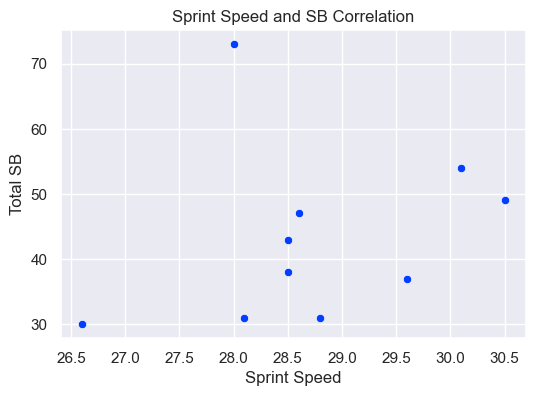

In [30]:
ax = sns.scatterplot(top_10_players, x='Sprint_Speed', y='R_Total_Stolen_Base')
ax.set_xlabel('Sprint Speed')
ax.set_ylabel('Total SB')
ax.set_title('Sprint Speed and SB Correlation');
corr = np.corrcoef(top_10_players['Sprint_Speed'], top_10_players['R_Total_Stolen_Base'])
corr

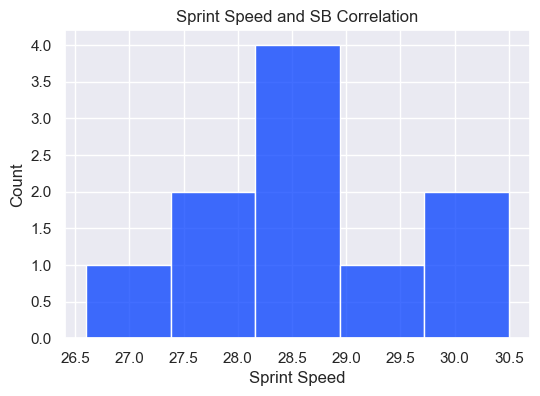

In [34]:
ax = sns.histplot(top_10_players, x='Sprint_Speed')
ax.set_xlabel('Sprint Speed')
ax.set_ylabel('Count')
ax.set_title('Sprint Speed and SB Correlation');

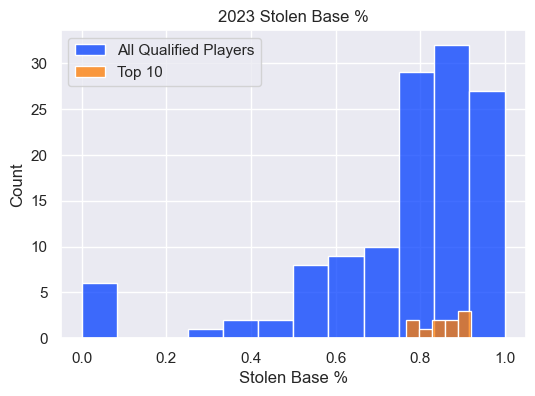

In [46]:
ax = sns.histplot(df_2023, x='Stolen_Base_%', label='All Qualified Players')
ax = sns.histplot(top_10_players, x='Stolen_Base_%', label='Top 10')
ax.set_xlabel('Stolen Base %')
ax.set_ylabel('Count')
ax.set_title('2023 Stolen Base %')

ax.legend();

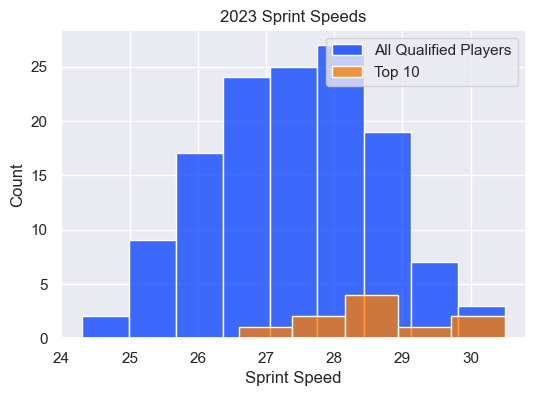

In [49]:
ax = sns.histplot(df_2023, x='Sprint_Speed', label='All Qualified Players')
ax = sns.histplot(top_10_players, x='Sprint_Speed', label='Top 10')
ax.set_xlabel('Sprint Speed')
ax.set_ylabel('Count')
ax.set_title('2023 Sprint Speeds')

ax.legend();

# Conclusions

This analysis has led me to the following two conclusions:
1. At a 5% significance level I reject the null hypothesis and accept the alternative hypothesis. Therefore, the increase in stolen bases from 2022 to 2023 ***was*** significant. Using a two-sample t-test, I found a the p-value to be less than the alpha level, and the t-statistic to be more extreme than the critical t-value. The numbers back the hype.
2. 

## Limitations

1. I used a rather **small dataset**. I analyzed the SB numbers based on the 2023 data, which has data from only 133 players. 

## Recommendations

1. Choose the players with **top Sprint Speeds** to focus on increasing SB attempts. While this seems intuitive, these players will have to **increase their ability to take risks**. This comes easier to some personality traits than others, so the coach will have to drill stolen base pracice and expect caught stealing to increase. The goal is to retain more viewers and attract more fans by increasing the action in the game. 

## Next Steps

1. I would like to **repeat this analysis** with a **larger dataset**, using all time data available. This would include analyzing SB over all the years and digging into increases and decreases. This also would include comparing stats from players with top SB over all the years to investigate any trends. I believe this could give me further insight into SB statistics.
2. 